# Penalised Unexplainability Network for Payments Per Claim Incurred

This notebook is intended to introduce the Penalised Unexplainability Network for Payments Per Claim Incurred model, a granular model for risk pricing and loss reserving, which separates out the "unexplainable" component of the residual network and assigns a separate penalty factor to it.

This model is intended to be useful where:

* Risk pricing where IBNR may vary with risk details, or
* Loss reserving where a mix shift has changed the portfolio significantly,
* and there is a reasonable sample size for a granular model to operate.

Firstly some imports:

In [1]:
import pandas as pd
import numpy as np
import punppci as pn
from punppci.example import fetch_example_data

Using TensorFlow backend.


In this example we will use a "claims" dataset which is based on airline delays. That has 12 columns of claim counts and paids.

In [2]:
prefix = "example"
num_cols = 12

# Get example data frame
df_full = fetch_example_data()

We'll mask the data at a certain date. All the claims past that date will get set to NaNs.

In [3]:
# Mask the bottom half of the triangle
df = pn.data_as_at(df_full, "origin_date", df_full.origin_date.agg("max"), "claim")
df.head()

,origin_date,carrier,flight,departing,destination,distance,ultimate_claim_count,ultimate_claim_size,expected_delay,claim_count_0,...,claim_paid_2,claim_paid_3,claim_paid_4,claim_paid_5,claim_paid_6,claim_paid_7,claim_paid_8,claim_paid_9,claim_paid_10,claim_paid_11
101131,2013-12-31,DL,457,JFK,SLC,1990,1,500.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95035,2013-12-31,B6,1843,EWR,PBI,1023,0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178230,2013-04-30,UA,1548,EWR,BOS,200,1,250.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
313567,2013-09-30,DL,801,JFK,PHX,2153,0,0.0,1.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22550,2013-01-31,DL,1919,LGA,MSP,1020,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.dtypes

origin_date             datetime64[ns]
carrier                         object
flight                           int64
departing                       object
destination                     object
distance                         int64
ultimate_claim_count             int64
ultimate_claim_size            float64
expected_delay                 float64
claim_count_0                  float64
claim_count_1                  float64
claim_count_2                  float64
claim_count_3                  float64
claim_count_4                  float64
claim_count_5                  float64
claim_count_6                  float64
claim_count_7                  float64
claim_count_8                  float64
claim_count_9                  float64
claim_count_10                 float64
claim_count_11                 float64
claim_paid_0                   float64
claim_paid_1                   float64
claim_paid_2                   float64
claim_paid_3                   float64
claim_paid_4             

We'll convert that into a PUNPPCI Dataset which enables various functions of this package.

In [5]:
# Make Dataset
ds = pn.Dataset(
    features=df[["carrier", "flight", "departing", "destination", "distance"]],
    origin=df.origin_date,
    exposure=None,   # Exposure weight is optional
    claim_count=df[["claim_count_{}".format(x) for x in range(0, num_cols)]],
    claim_paid=df[["claim_paid_{}".format(x) for x in range(0, num_cols)]]
)

df.groupby(["origin_date"]).agg('sum')

,flight,distance,ultimate_claim_count,ultimate_claim_size,expected_delay,claim_count_0,claim_count_1,claim_count_2,claim_count_3,claim_count_4,...,claim_paid_2,claim_paid_3,claim_paid_4,claim_paid_5,claim_paid_6,claim_paid_7,claim_paid_8,claim_paid_9,claim_paid_10,claim_paid_11
origin_date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,7397968,3855010,1528,2483650.0,3918.0,469.0,716.0,113.0,68.0,54.0,...,258500.0,219700.0,247450.0,169750.0,156450.0,90350.0,73200.0,93400.0,41350.0,122900.0
2013-02-28,7356231,3720379,1597,2980200.0,4127.0,469.0,694.0,138.0,83.0,58.0,...,299400.0,277800.0,249900.0,232200.0,196300.0,192050.0,142350.0,120800.0,50000.0,200750.0
2013-03-31,8747307,4368321,1653,3498100.0,5090.0,460.0,642.0,192.0,99.0,66.0,...,423800.0,309000.0,278900.0,318550.0,188450.0,126000.0,183050.0,142750.0,92700.0,0.0
2013-04-30,8527956,4424711,1945,4177050.0,5298.0,532.0,826.0,189.0,121.0,72.0,...,457450.0,417800.0,321150.0,372400.0,206450.0,223350.0,131750.0,129000.0,0.0,0.0
2013-05-31,8688181,4473809,1526,3406850.0,5102.0,374.0,606.0,188.0,99.0,72.0,...,418200.0,314200.0,323600.0,267650.0,208450.0,137950.0,208250.0,0.0,0.0,0.0
2013-06-30,8151702,4453931,1814,4791850.0,5711.0,470.0,674.0,180.0,130.0,98.0,...,438650.0,464350.0,457350.0,329400.0,309850.0,239600.0,0.0,0.0,0.0,0.0
2013-07-31,8333157,4509105,1926,5412450.0,6133.0,481.0,659.0,214.0,141.0,112.0,...,533950.0,481200.0,498450.0,463250.0,393350.0,0.0,0.0,0.0,0.0,0.0
2013-08-31,8389171,4588312,1727,3301850.0,4806.0,479.0,747.0,170.0,105.0,66.0,...,371750.0,339800.0,281650.0,239850.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-09-30,8160299,4187870,1051,1945950.0,4254.0,295.0,477.0,77.0,64.0,39.0,...,154100.0,181600.0,160600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This includes plotting the triangle as a Seaborn heatmap:

(<Figure size 864x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a37ae34a8>)

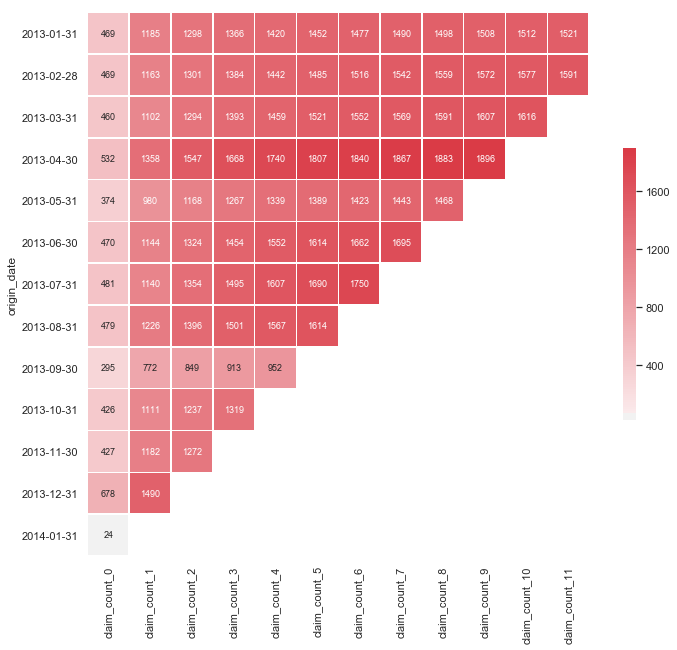

In [6]:
# Cumulative Count Triangle and Heat Map
ds.plot_triangle_claim_count()

(<Figure size 864x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a37abd630>)

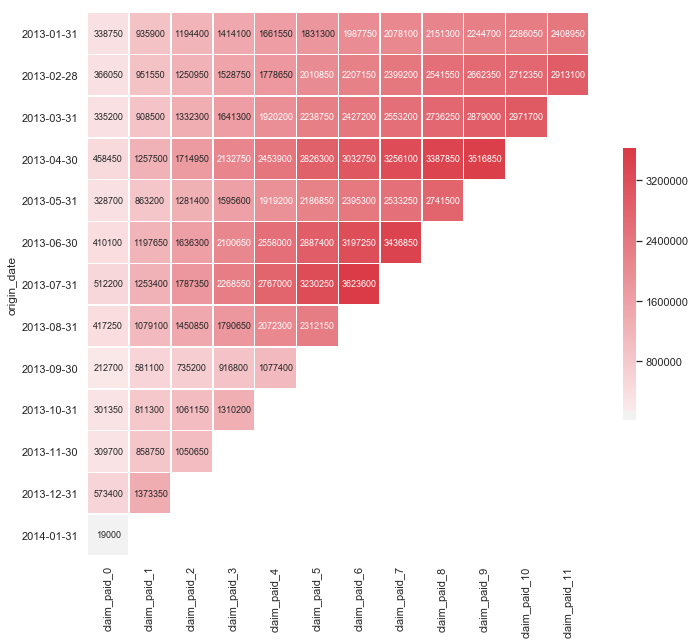

In [7]:
# Cumulative paid triangle and heatmap
ds.plot_triangle_claim_paid()

With this the bottom half of the triangle can be predicted using the traditional PPCI method:

(<Figure size 864x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a37a96208>)

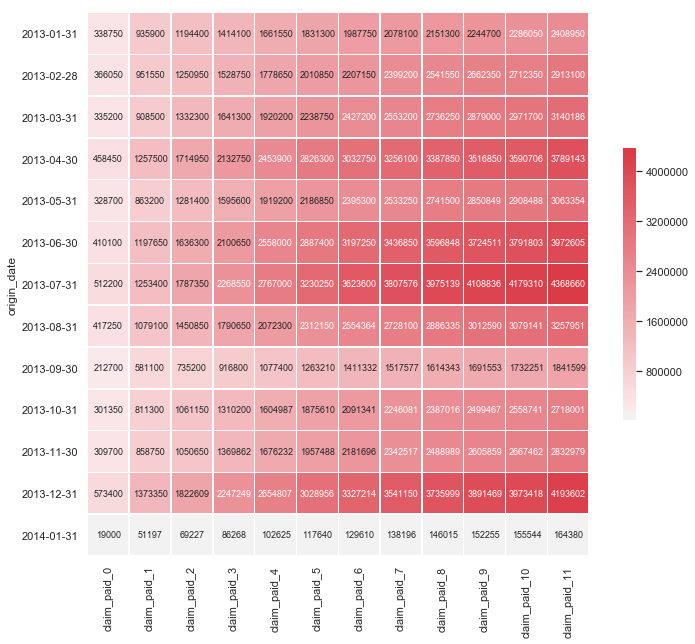

In [8]:
# Standard PPCI Projection
ds.plot_triangle_ppci()

However the primary goal of the package is to predict claims using the PUNPPCI model. 

We can create an Estimator based on a Dataset as follows - this will take on the list of predictors and the categories:

In [9]:
# Model - Make, Fit and Predict
model = pn.PUNPPCILossEstimator(dataset=ds)

In [10]:
# Fit with optional exposure weights
model.fit(ds.X(), ds.y(), w=ds.w())

Instructions for updating:
Colocations handled automatically by placer.
Set initial loss weights to be 2.5283135088531585 for count and 0.0012929447990089526 for paid
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
carrier (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
departing (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
destination (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embed_develop_countcarrier0 (Em (None, 1,

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
50000/50000 [==============================] - 12s 237us/step - loss: nan - claim_count_loss: nan - claim_paid_loss: 173186.2384
Epoch 2/20
50000/50000 [==============================] - 9s 180us/step - loss: 223.6614 - claim_count_loss: 0.1039 - claim_paid_loss: 172651.8690
Epoch 3/20
50000/50000 [==============================] - 9s 184us/step - loss: 223.5305 - claim_count_loss: 0.1037 - claim_paid_loss: 172601.7171
Epoch 4/20
50000/50000 [==============================] - 9s 181us/step - loss: 223.4585 - claim_count_loss: 0.1036 - claim_paid_loss: 172556.3708
Epoch 5/20
50000/50000 [==============================] - 9s 181us/step - loss: 223.4096 - claim_count_loss: 0.1036 - claim_paid_loss: 172541.4963
Epoch 6/20
50000/50000 [==============================] - 9s 180us/step - loss: 223.4130 - claim_count_loss: 0.1035 - claim_paid_loss: 172532.2910
Epoch 7/20
50000/50000 [==============================] - 9s 181us/step - los

PUNPPCILossEstimator(category_levels=[16, 3, 102],
           category_names=['carrier', 'departing', 'destination'],
           claim_count_names=['claim_count_0', 'claim_count_1', 'claim_count_2', 'claim_count_3', 'claim_count_4', 'claim_count_5', 'claim_count_6', 'claim_count_7', 'claim_count_8', 'claim_count_9', 'claim_count_10', 'claim_count_11'],
           claim_count_scale=2.5283135088531585,
           claim_paid_names=['claim_paid_0', 'claim_paid_1', 'claim_paid_2', 'claim_paid_3', 'claim_paid_4', 'claim_paid_5', 'claim_paid_6', 'claim_paid_7', 'claim_paid_8', 'claim_paid_9', 'claim_paid_10', 'claim_paid_11'],
           claim_paid_scale=0.0012929447990089526, clipnorm=None,
           dense_layers_development=3, dense_layers_pricing=3,
           dense_size_development=64, dense_size_pricing=64, epochs=20,
           feature_names=['origin', 'carrier', 'departing', 'destination', 'flight', 'distance'],
           l1_l2_lin_development=0.001, l1_l2_lin_pricing=0.001,
        

The weights within the final model of linear vs residual neural network components can be displayed as follows:

In [11]:
# Explained vs Unexplained factors
model.linear_vs_residual()

,Linear,Residual Network
risk_count_ultimate_claim_count,NaN,NaN
risk_size_ultimate_claim_size,NaN,NaN
development_count,NaN,NaN
development_paid,NaN,NaN


The model is a standard scikit-learn estimator, so predictions can be generated in the usual way:

In [12]:
# Predict values
model.predict(ds.X()).head(5)

,claim_count_0,claim_count_1,claim_count_2,claim_count_3,claim_count_4,claim_count_5,claim_count_6,claim_count_7,claim_count_8,claim_count_9,...,claim_paid_2,claim_paid_3,claim_paid_4,claim_paid_5,claim_paid_6,claim_paid_7,claim_paid_8,claim_paid_9,claim_paid_10,claim_paid_11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Partial dependence plots are included with the package using PDPBox:

In [13]:
# Partial Dependence - Frequency
model.plot_pdp_frequency(ds, 'distance')

KeyboardInterrupt: 

In [ ]:
# Partial Dependence - Frequency
model.plot_pdp_frequency(ds, 'origin')

The network graph can also be displayed, but a smaller scale may be needed to fit on screen.

In [ ]:
from IPython.display import HTML
# Smaller graph so it can fit on screen
style = "<style>svg{width:35% !important;height:50% !important;}</style>"
HTML(style)

In [ ]:
# Explanations and Diagnostics
model.plot_graph()

The model can be used to project the bottom half of the triangle:

In [ ]:
ds.plot_triangle_model(model)

With the true data, we can benchmark the model against the the standard PPCI model.

This calculates the sum squared error of the PUNPPCI and the PPCI methods vs the true bottom half of the triangle.

In [ ]:
ds_true = pn.Dataset(
    features=df_full[["carrier", "flight", "departing", "destination", "distance"]],
    origin=df_full.origin_date,
    exposure=None,   # Exposure weight is optional
    claim_count=df_full[["claim_count_{}".format(x) for x in range(0, num_cols)]],
    claim_paid=df_full[["claim_paid_{}".format(x) for x in range(0, num_cols)]]
)

In [ ]:
bench_mod = pn.benchmark(ds, model, ds_true)
bench_mod

Lower is better.

With the true data, the actual vs model relationships for each factor can also be benchmarked:

In [ ]:
pn.plot_actual_vs_model(ds_true, model, "distance")

In [ ]:
pn.plot_actual_vs_model(ds_true, model, "origin")

The average payment per claim incurred between the two methods can also be compared:

In [ ]:
ds.ppci(output="selections")

In [ ]:
ds.ppci_model(model)

Benchmark code:

In [21]:
models, lin_vs_res, bench_mod_reserve, bench_mod_price = pn.benchmark_test_suite(
    df_full,
    n_list=[5000, 5000, 10000, 10000],
    v_list=range(0, 4),
    features=["carrier", "flight", "departing", "destination", "distance"],
    origin="origin_date",
    exposure=None,   # Exposure weight is optional
    claim_count=["claim_count_{}".format(x) for x in range(0, num_cols)],
    claim_paid=["claim_paid_{}".format(x) for x in range(0, num_cols)],
    claim_prefix="claim",
    as_at=df.origin_date.agg("max")
)

Set initial loss weights to be 2.49109550598843 for count and 0.0012200892904507834 for paid
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
carrier (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
departing (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
destination (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embed_develop_countcarrier0 (Em (None, 1, 1)         16          carrier[0][0]                    
________________

------------------------------------------------------------------
For test case #0 with n=5000
PPCI Average Claim Size: 2016.1485862083039 vs Model: 2864.05126953125
Average frequency: 0.4056116426536655 vs Model: 1.3495479822158813
Linear vs residual of:
                                   Linear  Residual Network
risk_count_ultimate_claim_count  0.500036          0.499964
risk_size_ultimate_claim_size    0.966465          0.033535
development_count                0.977604          0.022396
development_paid                 0.999842          0.000158
PPCI vs Model Errors of:
       claim_count_0  claim_count_1  claim_count_2  claim_count_3  \
PPCI             0.0       0.008332      10.896855       9.730256   
Model            0.0       0.358103       0.344521       5.426354   

       claim_count_4  claim_count_5  claim_count_6  claim_count_7  \
PPCI       24.279099      61.155078      63.698739      64.681511   
Model      10.434401      16.322914      13.625864      17.956395   

  

------------------------------------------------------------------
For test case #1 with n=5000
PPCI Average Claim Size: 1818.0520128989858 vs Model: 1791.5430908203125
Average frequency: 0.398976363692573 vs Model: 1.4655201435089111
Linear vs residual of:
                                   Linear  Residual Network
risk_count_ultimate_claim_count  0.866501          0.133499
risk_size_ultimate_claim_size    0.612406          0.387593
development_count                0.045706          0.954294
development_paid                 0.970963          0.029036
PPCI vs Model Errors of:
       claim_count_0  claim_count_1  claim_count_2  claim_count_3  \
PPCI             0.0       1.515176       2.340309       6.750788   
Model            0.0       0.064144       6.750853      12.049942   

       claim_count_4  claim_count_5  claim_count_6  claim_count_7  \
PPCI       10.069706      22.271667      21.244649      27.750815   
Model      29.676110      29.423507      24.304920      30.223146   

 

------------------------------------------------------------------
For test case #2 with n=10000
PPCI Average Claim Size: 1924.4554775514237 vs Model: 2410.15478515625
Average frequency: 0.3991907591226676 vs Model: 1.3870809078216553
Linear vs residual of:
                                   Linear  Residual Network
risk_count_ultimate_claim_count  0.503608          0.496392
risk_size_ultimate_claim_size    0.968371          0.031629
development_count                1.000000         -0.000000
development_paid                 0.958319          0.041681
PPCI vs Model Errors of:
       claim_count_0  claim_count_1  claim_count_2  claim_count_3  \
PPCI             0.0       0.699001       1.897489      13.975284   
Model            0.0       0.388263       8.688190      21.962663   

       claim_count_4  claim_count_5  claim_count_6  claim_count_7  \
PPCI       36.103588      51.972455      74.610611      83.577255   
Model      38.985170      65.517019      82.008728     123.685004   

 

------------------------------------------------------------------
For test case #3 with n=10000
PPCI Average Claim Size: 1899.8825975924321 vs Model: 2222.707275390625
Average frequency: 0.4000600052252811 vs Model: 1.343558669090271
Linear vs residual of:
                                   Linear  Residual Network
risk_count_ultimate_claim_count  0.978879          0.021121
risk_size_ultimate_claim_size    1.000000          0.000000
development_count                0.976067          0.023933
development_paid                 0.991384          0.008616
PPCI vs Model Errors of:
       claim_count_0  claim_count_1  claim_count_2  claim_count_3  \
PPCI             0.0       0.630271       1.460276       8.067393   
Model            0.0       0.680558      17.660213      85.383743   

       claim_count_4  claim_count_5  claim_count_6  claim_count_7  \
PPCI       27.385167      71.587507     124.204901     165.696823   
Model     129.645860     147.588943     167.149050     182.970147   

 

Hyperparameter Bayesian grid search functionality is also included. To do so, use the PUNPPCILossOptimizer:

In [ ]:
# Model - Make, Fit and Predict
opt = pn.PUNPPCILossOptimizer(dataset=ds)

In [ ]:
# Fit with optional weights
opt.fit(ds.X(), ds.y(), w=ds.w())

For both models, it is possible to just predict frequency and size.

In [ ]:
# Predict frequency
opt.predict(ds.X(), response_variable="frequency")[0:5]

In [ ]:
# Predict size
opt.predict(ds.X(), response_variable="size")[0:5]

Partial dependence works for the Optimizer in the same way as the Regressor:

In [ ]:
# Partial Dependence - Frequency
opt.plot_pdp_frequency(ds, 'distance')

In [ ]:
opt.plot_pdp_frequency(ds, 'origin')

In [ ]:
opt.plot_pdp_size(ds, 'distance')

In [ ]:
# Partial Dependence - Size
opt.plot_pdp_size(ds, 'carrier')

With hyperparameters optimised, we can revisit the balance between the linear and residual networks, and the benchmarks. 

In [ ]:
# Explained vs Unexplained factors
opt.linear_vs_residual()

In [ ]:
bench_opt = pn.benchmark(ds, opt, ds_true)
bench_opt

Finally model predictions from each method can be exported to CSV:

In [ ]:
# Output Counts - to CSV
ds.chain_ladder_count(output="projection").to_csv(f"output/{prefix}_count_ppci.csv")
ds.count_model(model, output="projection").to_csv(f"output/{prefix}_count_model.csv")
ds.count_model(opt, output="projection").to_csv(f"output/{prefix}_count_opt.csv")
ds_true.claim_count \
  .assign(origin_date=ds_true.origin) \
  .groupby(["origin_date"]).agg("sum") \
  .cumsum(axis=1).to_csv(f"output/{prefix}_count_true.csv")

# Output Paid - to CSV
ds.ppci(output="projection").to_csv(f"output/{prefix}_paid_ppci.csv")
ds.paid_model(model, output="projection").to_csv(f"output/{prefix}_paid_model.csv")
ds.paid_model(opt, output="projection").to_csv(f"output/{prefix}_paid_opt.csv")
ds_true.claim_paid \
  .assign(origin_date=ds_true.origin) \
  .groupby(["origin_date"]).agg("sum") \
  .cumsum(axis=1).to_csv(f"output/{prefix}_paid_true.csv")